In [1]:
# Package imports
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import t7utils as t7

%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

%load_ext autoreload
%autoreload 2

**Notation:**

- $n_H$, $n_W$ and $n_C$: height, width and channel count of a given layer
- lowerscript $i$: $i^{th}$ refers to the $i^{th}$ vector entry
- superscript $[k]$ refers to an object of the $k^{th}$ layer 
- superscript $(i)$ refers object from the $i^{th}$ example. 

<br/>

---

## A. Convolutional Layer Foward Propagation ##

### 1. Zero Padding ###

A convolution layer (CONV) transforms an input tensor into an output tensor of different size. For 2D data such as images, tensor dimensions are generally $n_H \times n_W \times n_C$. A first step consists in zero padding the input volume. This permits to use a CONV layer without reducing the width and height of the output volume. This is important when considering deeper networks as each CONV will shrink width/height. A special case is the "same" convolution where width/height are preserved after convolution (padding is set to 1/2 of the kernel size reduced by 1). Padding helps preserving information at the border of an image. Without padding, fewer values in the next activation maps would be affected by pixels at the edges.

<figure style="text-align:center; width:80%; margin:auto;">
    <img src="figs/zero-padding.png" style="width: 100%;"/>
  <figcaption>
    <b>Figure 1:</b> Zero-padding
  </figcaption>
</figure>
<br/>

*Hint:* Use [np.pad](https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html) to pad input tensor e.g. if you want to zero-pad `X` of shape $(2000, 32, 32, 3)$,

```python
Y = np.pad(X, ((0,0), (2,2), (2,2), (0,0)), 'constant')
```
will result in tensor or shape `(2000, 34, 34, 3)`.


In [2]:
# Zero-padding
def zero_pad(X, pad):
    """
    Zero-pad input tensor X, where padding is applied to height 
    and width as shown in Figure 1
    
    Argument:
    X -- a numpy array of shape (n, n_H, n_W, n_C)
    pad -- integer, amount of padding around height and width
    
    Returns:
    X_pad -- padded numpy array of shape (n, n_H + 2 * pad, n_W + 2 * pad, n_C)
    """
    
    X_pad = np.pad(X,((0,0),(pad,pad),(pad,pad),(0,0)),'constant')
    
    return X_pad

X.shape = (32, 8, 8, 3)
X_pad.shape = (32, 12, 12, 3)


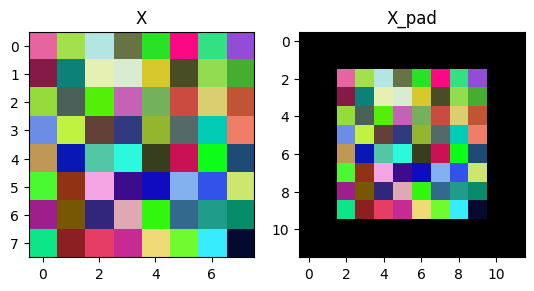

In [3]:
# testing
X = t7.zero_pad_test()
print("X.shape = {}".format(X.shape))
X_pad = zero_pad(X, 2)
print("X_pad.shape = {}".format(X_pad.shape))

_, figs = plt.subplots(1, 2)
figs[0].set_title('X')
figs[1].set_title('X_pad')
figs[0].imshow(X[0,:,:,:])
figs[1].imshow(X_pad[0,:,:,:])
figs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

### 2. Convolution Step (Window Correlation) ###

Let's implement a single step of convolution by applying the filter kernel to a slice of the previous activation and corresponding to a single position of the input. The convolutional output will then be obtained by applying this single step at every position of the input.

<br/>
<figure style="text-align:center; width:80%; margin:auto;">
  <img src="figs/convolution.png" style="width:100%;"/>
  <figcaption>
    <b>Figure 2:</b> Convolution operation with a kernel of 3&times;3 with<br/>
    a stride (step of sliding window) of 3 assuming zero bias
  </figcaption>
</figure>
<br/> 

Each value in the left matrix corresponds to a single pixel value. We convolve a $3\times 3$ filter with the image by multiplying its values element-wise, summing up and adding a bias.


In [4]:
# Single convolution step
def conv_step(a_prev_slice, W, b):
    """
    Apply conv filter (W, b) on single slice
    
    Arguments:
    a_prev_slice -- input slice of shape (n_f, n_f, n_C_prev)
    W -- weight matrix of shape (n_f, n_f, n_C_prev)
    b -- bias scalar
    
    Returns:
    z -- scalar
    """
   
    z = np.sum(a_prev_slice*W)+b

    return z

In [5]:
# testing
a_prev_slice, W, b = t7.conv_step_test()
z = conv_step(a_prev_slice, W, b)
print("z = {:.3f}".format(z))

z = -7.636


In [6]:
# Forward convolution
def conv_fwd(A_prev, W, b, params):
    """
    Implements convolution forward propagation 
    
    Arguments:
    A_prev -- activations of previous layer, array of shape (n, n_H_prev, n_W_prev, n_C_prev)
    W -- weights tensor of shape (n_f, n_f, n_C_prev, n_C)
    b -- bias vector of shape (1, 1, 1, n_C)
    params -- python dictionary 
        stride -- integer
        padding -- integer 
        
    Returns:
    Z -- convolution output tensor of shape (n, n_H, n_W, n_C)
    cache -- dictionary for backprop
        A_prev -- activations of previous layer, array of shape (n, n_H_prev, n_W_prev, n_C_prev)
        W -- weights tensor of shape (n_f, n_f, n_C_prev, n_C)
        b -- bias vector of shape (1, 1, 1, n_C)
        params -- python dictionary 
            stride -- integer
            padding -- integer 
    """
    
    (n, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape # Retrieve dimensions
    (n_f, n_f, n_C_prev, n_C) = W.shape # Retrieve dimensions
    stride = params["stride"] # Retrieve stride
    padding = params["padding"] # Retrieve padding
    n_H = int((n_H_prev-n_f + 2*padding)/stride)+1 # Compute kernel width
    n_W = int((n_W_prev-n_f + 2*padding)/stride)+1 # Compute kernel height
    Z = np.zeros((n,n_H,n_W,n_C)) # Initialize output tensor with zeros
    A_prev_pad = np.pad(A_prev,((0,0),(padding,padding),(padding,padding),(0,0)),'constant') # Pad input activation maps

    for i in range(n):                    # batch loop
        a_prev_pad = A_prev_pad[i,:,:,:]  # select ith training padded activation  
        for h in range(n_H):              # height loop
            for w in range(n_W):          # width loop
                for c in range(n_C):      # channel (# of filter) loop
                    h_range = stride*h
                    w_range = w*stride
                    a_slice_prev = a_prev_pad[h_range:h_range + n_f,w_range:w_range+n_f,:] # slice of a_prev_pad
                    Z[i, h, w, c] = np.sum(a_slice_prev*W[:,:,:,c])+b[:,:,:,c] # convolve slice with filter c

    assert(Z.shape == (n, n_H, n_W, n_C))
    cache = {}
    cache['A_prev'] = A_prev
    cache['W'] = W
    cache['b'] = b
    cache['params'] = params

    return Z, cache

In [7]:
# testing
A_prev, W, b, params = t7.conv_fwd_test()
Z, cache = conv_fwd(A_prev, W, b, params)
print("mean(Z) = {:.3f}".format(np.mean(Z)))
print("cache.keys = {}".format([key for key in cache.keys()]))

/tmp/ipykernel_3142/1775965250.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z[i, h, w, c] = np.sum(a_slice_prev*W[:,:,:,c])+b[:,:,:,c] # convolve slice with filter c


mean(Z) = -0.162
cache.keys = ['A_prev', 'W', 'b', 'params']


In [8]:
# Convolutional layer forward propagation ReLU activation
def convlayer_fwd(A_prev, W, b, params):
    """
    Conv layer forward propagation (conv + non-linearity)
    
    Arguments:
    A_prev -- activations of previous layer, array of shape (n, n_H_prev, n_W_prev, n_C_prev)
    W -- weights tensor of shape (n_f, n_f, n_C_prev, n_C)
    b -- bias vector of shape (1, 1, 1, n_C)
    params -- python dictionary 
        stride -- integer
        padding -- integer 
        
    Returns:
    A -- activation output tensor of shape (n, n_H, n_W, n_C)
    cache -- dictionary for backprop
        CONV -- dictionary convolution cache
        ACTIVATION -- dictionary activation cache  
    """
        
    Z, conv_cache = conv_fwd(A_prev,W,b,params)
    A, activation_cache = t7.relu_fwd(Z)
    return A, {'CONV': conv_cache, 'ACTIVATION': activation_cache}

In [9]:
# testing
A_prev, W, b, params = t7.conv_fwd_test()
A, cache = convlayer_fwd(A_prev, W, b, params)
print("mean(A) = {:.3f}".format(np.mean(A)))
print("cache.keys = {}".format([key for key in [[key for key in value.keys()] for _, value in cache.items()]]))

/tmp/ipykernel_3142/1775965250.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z[i, h, w, c] = np.sum(a_slice_prev*W[:,:,:,c])+b[:,:,:,c] # convolve slice with filter c


mean(A) = 1.946
cache.keys = [['A_prev', 'W', 'b', 'params'], ['Z']]


In [10]:
# Backward convolution
def conv_back(dZ, cache):
    """
    Implements convolution backward propagation 
    
    Arguments:
    dZ -- gradient of loss with respect to conv layer output, array of shape (n, n_H, n_W, n_C)
    cache -- dictionary for backprop
        A_prev -- activations of previous layer, array of shape (n, n_H_prev, n_W_prev, n_C_prev)
        W -- weights tensor of shape (n_f, n_f, n_C_prev, n_C)
        b -- bias vector of shape (1, 1, 1, n_C)
        params -- python dictionary 
            stride -- integer
            padding -- integer 
    
    Returns:
        dW -- gradient of loss with respect to current layer weights, shape (n_f, n_f, n_C_prev, n_C)
        db -- gradient of loss with respect to current layer bias, shape (1, 1, 1, n_C)
        dA_prev -- gradient of loss with respect to activation of previous layer output, shape (n, n_H_prev, n_W_prev, n_C_prev)
    """    
    
    A_prev = cache['A_prev'] # Retrieve from forward prop cache
    W = cache['W'] # Retrieve from forward prop cache
    b = cache['b'] # Retrieve from forward prop cache
    params = cache['params'] # Retrieve from forward prop cache
    (n, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape # Retrieve dimensions
    (n_f, n_f, n_C_prev, n_C) = W.shape # Retrieve dimensions
    stride = params["stride"] # Retrieve stride
    padding = params["padding"] # Retrieve padding
    (n, n_H, n_W, n_C) = dZ.shape # Retrieve dimensions
    A_prev_pad = np.pad(A_prev,((0,0),(padding,padding),(padding,padding),(0,0)),'constant') # Pad A_prev
    dA_prev_pad = np.zeros_like(A_prev_pad) # Initialise dA_prev_pad
    dW = np.zeros_like(W) # Initialise dW
    db = np.zeros_like(b) # Initialise db
    dA_prev = np.zeros_like(A_prev) # Initialise dA_prev

    
    for i in range(n):                    # batch loop
        a_prev_pad = A_prev_pad[i,:,:,:]  # select ith training padded activation  
        da_prev_pad = dA_prev_pad[i,:,:,:]# select ith training padded activation gradient  
        for h in range(n_H):              # height loop
            for w in range(n_W):          # width loop
                for c in range(n_C):      # channel (# of filter) loop
                    h_range = stride*h
                    w_range = stride*w
                    a_slice = a_prev_pad[h_range:h_range+n_f,w_range:w_range + n_f,:] # slice of a_prev_pad
                    da_prev_pad[h_range:h_range + n_f, w_range:w_range+n_f,:] += dZ[i,h,w,c]*W[:,:,:,c]
                    dW[:, :, :, c] += dZ[i,h,w,c]*a_slice
                    db[:, :, :, c] += dZ[i,h,w,c]
        
        dA_prev[i, :, :, :] = da_prev_pad[padding:-padding,padding:-padding,:] if padding != 0 else da_prev_pad # Remove padding
    
    assert(dA_prev.shape == (n, n_H_prev, n_W_prev, n_C_prev))
    
    return dA_prev, dW, db

In [11]:
# testing
A_prev, W, b, params = t7.conv_fwd_test()
Z, cache_conv = conv_fwd(A_prev, W, b, params)
dA, dW, db = conv_back(Z, cache_conv)
print("mean(dA) = {:.3f}".format(np.mean(dA)))
print("mean(dW) = {:.3f}".format(np.mean(dW)))
print("mean(db) = {:.3f}".format(np.mean(db)))

/tmp/ipykernel_3142/1775965250.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z[i, h, w, c] = np.sum(a_slice_prev*W[:,:,:,c])+b[:,:,:,c] # convolve slice with filter c


mean(dA) = 0.961
mean(dW) = 1162.824
mean(db) = -6010.032


In [12]:
# Convolutional layer backward propagation with ReLU activation
def convlayer_back(dA, cache):
    """
    Single convolutional layer backprop

    Arguments:
    dA -- gradient of loss with respect to activation
    cache -- dictionary from forward propagation
        CONV -- dictionary convolution cache
        ACTIVATION -- dictionary activation cache 

    Returns:
    dW -- gradient of loss with respect to current layer weights
    db -- gradient of loss with respect to current layer bias
    dA_prev -- gradient of loss with respect to activation of previous layer output
    """
    
    conv_cache = cache['CONV']
    activation_cache = cache['ACTIVATION']
    
    dZ = t7.relu_back(dA,activation_cache)
    dW, db, dA_prev = conv_back(dZ,conv_cache)
    
    return dW, db, dA_prev

In [13]:
# testing
dA, cache = t7.convlayer_back_test()
dW, db, dA_prev = convlayer_back(dA, cache)
print("mean(dA_prev) = {:.3f}".format(np.mean(dA_prev)))
print("mean(dW) = {:.3f}".format(np.mean(dW)))
print("mean(db) = {:.3f}".format(np.mean(db)))

mean(dA_prev) = -50.620
mean(dW) = -0.010
mean(db) = 6.885


In [14]:
# Pooling layer forward propagation
def pool_fwd(A_prev, params):
    '''
    Implements pooling forward propagation 
    
    Arguments:
    A_prev -- activations of previous layer, tensor of shape (n, n_H_prev, n_W_prev, n_C_prev)
    params -- python dictionary 
        stride -- integer
        n_f -- integer
        pool_mode -- string either 'max' or 'avg'
    
    Returns:
    A -- pool layer output, tensor of shape (n, n_H_prev, n_W_prev, n_C_prev)
    cache -- dictionary for backprop
        A_prev -- pool layer input
        stride -- integer
        n_f -- integer
        pool_mode -- string either 'max' or 'avg'
    '''
    
    (n, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape # Retrieve dimensions
    stride = params['stride'] # Retrieve stride
    n_f = params['n_f'] # Retrieve n_f
    pool_mode = params['pool_mode'] # Retrieve POOL mode
    n_H = int((n_H_prev-n_f)/stride)+1 # output dimensions
    n_W = int((n_W_prev-n_f)/stride)+1 # output dimensions
    n_C = n_C_prev # output dimensions
    A = np.zeros((n,n_H,n_W,n_C)) # init output            
    
    for i in range(n):                    # batch loop
        for h in range(n_H):              # height loop
            for w in range(n_W):          # width loop
                for c in range(n_C):      # channel loop
                    h_range = stride*h  
                    w_range = stride*w 
                    a_prev_slice = A_prev[i,h_range:h_range+n_f, w_range:w_range+ n_f,c] # c-th channel slice of i-th sample of A_prev
                    if pool_mode == 'max':
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif pool_mode == 'avg': 
                        A[i, h, w, c] = np.mean(a_prev_slice)
        
    cache = {}
    cache['A_prev'] = A_prev # create cache for backprop
    cache['stride'] = stride # create cache for backprop
    cache['n_f'] = n_f # create cache for backprop
    cache['pool_mode'] = pool_mode # create cache for backprop
    
    assert(A.shape == (n, n_H, n_W, n_C))
    return A, cache

mean(A_maxpool) = 0.900
mean(A_avgpool) = 0.501
3x3 CONV with stride 3


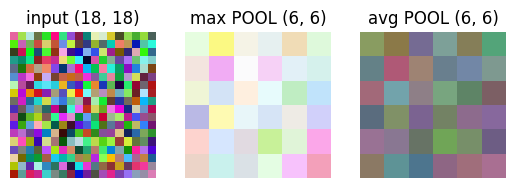

In [15]:
# testing
A_prev, max_params, avg_params = t7.pool_fwd_test()
A_maxpool, cache = pool_fwd(A_prev, max_params)
A_avgpool, _ = pool_fwd(A_prev, avg_params)
print("mean(A_maxpool) = {:.3f}".format(np.mean(A_maxpool)))
print("mean(A_avgpool) = {:.3f}".format(np.mean(A_avgpool)))
print("{}x{} CONV with stride {}".format(cache['n_f'], cache['n_f'], cache['stride']))

_, figs = plt.subplots(1, 3)
figs[0].set_title('input {}'.format(A_prev.shape[1:3]))
figs[1].set_title('max POOL {}'.format(A_maxpool.shape[1:3]))
figs[2].set_title('avg POOL {}'.format(A_avgpool.shape[1:3]))
figs[0].imshow(A_prev[0,:,:,:])
figs[1].imshow(A_maxpool[0,:,:,:])
figs[2].imshow(A_avgpool[0,:,:,:])
_ = [fig.axis('off') for _, fig in np.ndenumerate(figs)]

In [16]:
def slice_mask(a_slice, pool_mode):
    """
    Creates a mask from input sclice
    
    Arguments:
    a_slice -- Array of shape (n_f, n_f)
    pool_mode -- String either 'max' or 'avg'
    
    Returns:
    mask -- Array of shape (n_f, n_f)
    """
    
    if pool_mode == 'max':
        mask = (a_slice == np.max(a_slice)).astype(float)/np.sum(a_slice==np.max(a_slice))
    elif pool_mode == 'avg': 
        mask = np.ones_like(a_slice)/a_slice.size
    mask = mask
    
    return mask

In [17]:
# testing
np.random.seed(2019) # for reproducibility
a_slice = np.round(10 * np.random.rand(2, 3))
print('a_slice:')
print('{}'.format(a_slice))
mask = slice_mask(a_slice, 'max')
print('max mask:')
print('{}'.format(mask))
mask = slice_mask(a_slice, 'avg')
print('avg mask:')
print('{}'.format(mask))

a_slice:
[[9. 4. 6.]
 [6. 9. 3.]]
max mask:
[[0.5 0.  0. ]
 [0.  0.5 0. ]]
avg mask:
[[0.167 0.167 0.167]
 [0.167 0.167 0.167]]


In [18]:
# Pooling layer backward propagation
def pool_back(dA, cache):
    """
    Implements pooling backward propagation 
    
    Arguments:
    dA -- gradient of loss with respect to pooling layer output, same shape as A
    cache -- dictionary for backprop
        A_prev -- pool layer input
        stride -- integer
        n_f -- integer
        pool_mode -- string either 'max' or 'avg'
    
    Returns:
    dA_prev -- gradient of loss with respect to pooling layer input, same shape as A_prev
    """
    
    A_prev = cache['A_prev'] # Retrieve A_prev from cache
    stride = cache['stride'] # Retrieve stride from cache
    n_f = cache['n_f'] # Retrieve n_f from cache
    pool_mode = cache['pool_mode'] # Retrieve POOL mode from cache
    n, n_H_prev, n_W_prev, n_C_prev = A_prev.shape # Retrieve dimensions
    _, n_H, n_W, n_C = dA.shape # Retrieve dimensions
    dA_prev = np.zeros_like(A_prev) # Initialize dA_prev with zeros

    
    for i in range(n):                    # batch loop
        a_prev = A_prev[i, :, :, :]       # select training example from A_prev
        for h in range(n_H):              # height loop
            for w in range(n_W):          # width loop
                for c in range(n_C):      # channel loop
                    h_range = stride*h
                    w_range = stride*w
                    a_prev_slice = a_prev[h_range:h_range+n_f,w_range:w_range+n_f,c] # c-th channel slice of i-th sample of A_prev
                    mask = slice_mask(a_prev_slice,pool_mode) # Create the mask from a_prev_slice
                    dA_prev[i,h_range:h_range+n_f,w_range:w_range+n_f,c] += dA[i,h,w,c]*mask # Increment dA_prev by mask multiplied by scalar entry of dA

    assert(dA_prev.shape == A_prev.shape)    
    return dA_prev

max-pool: mean(dA_prev) = 0.055, std(dA_prev) = 0.184
avg-pool: mean(dA_prev) = 0.055, std(dA_prev) = 0.032


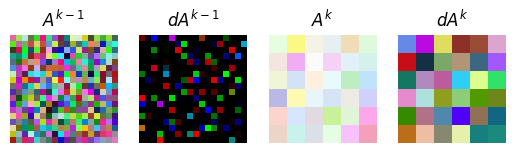

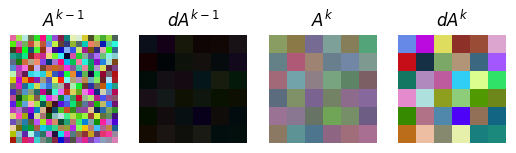

In [19]:
# testing
A_prev, max_params, avg_params = t7.pool_fwd_test()

A, cache = pool_fwd(A_prev, max_params)
dA = np.random.rand(*A.shape)
dA_prev = pool_back(dA, cache)
print("{}-pool: mean(dA_prev) = {:.3f}, std(dA_prev) = {:.3f}".format(cache['pool_mode'], np.mean(dA_prev), np.std(dA_prev)))

_, figs = plt.subplots(1, 4)
figs[0].imshow(A_prev[0,:,:,:])
figs[1].imshow(dA_prev[0,:,:,:])
figs[2].imshow(A[0,:,:,:])
figs[3].imshow(dA[0,:,:,:])
figs[0].set_title('$A^{k-1}$')
figs[1].set_title('$dA^{k-1}$')
figs[2].set_title('$A^{k}$')
figs[3].set_title('$dA^{k}$')
_ = [fig.axis('off') for _, fig in np.ndenumerate(figs)]

A, cache = pool_fwd(A_prev, avg_params)
dA_prev = pool_back(dA, cache)
print("{}-pool: mean(dA_prev) = {:.3f}, std(dA_prev) = {:.3f}".format(cache['pool_mode'], np.mean(dA_prev), np.std(dA_prev)))

_, figs = plt.subplots(1, 4)
figs[0].imshow(A_prev[0,:,:,:])
figs[1].imshow(dA_prev[0,:,:,:])
figs[2].imshow(A[0,:,:,:])
figs[3].imshow(dA[0,:,:,:])
figs[0].set_title('$A^{k-1}$')
figs[1].set_title('$dA^{k-1}$')
figs[2].set_title('$A^{k}$')
figs[3].set_title('$dA^{k}$')
_ = [fig.axis('off') for _, fig in np.ndenumerate(figs)]